[dim, RMSE, NRMSE]
[0, 0.5369169594203332, 0.06914752909490844]
[1, 1.96365954243883, 0.22010509782282883]
[2, 3.565208661833713, 0.40806872615033235]
[3, 0.34563246409545867, 0.03394749850687944]
[4, 1.106996143151028, 0.09124508621210656]
[5, 1.119352211835147, 0.08052075226494367]


C:\Users\gouhe\anaconda3\lib\site-packages\ipykernel_launcher.py:141: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


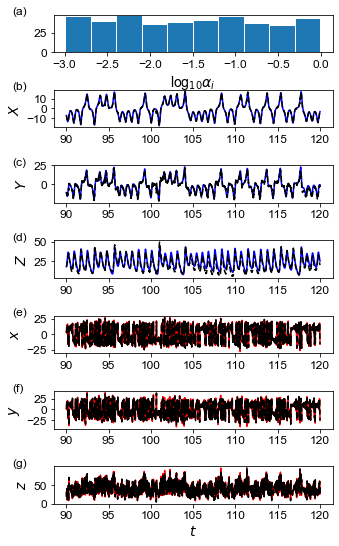

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

#################################################################
# pred_tcLorenz.py: prediction of two-coupled Lorenz model
# (cf. Borra, PRE, 2020; Boffetta et al., J. Atomos. Sci., 1998)
# (c) 2021 Gouhei Tanaka
# Citation:
# Tanaka et al., "Reservoir computing with diverse timescales for 
# prediction of multiscale dynamics", arXiv:2108.09446
#################################################################

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from esn_dts import ESN, Tikhonov


np.random.seed(seed=0)

# return dv/dt
def model(v,t,a,b,c,r_s,r_f,eps_s,eps_f):
    dXdt = a*(v[1]-v[0])
    dYdt = r_s*v[0]-v[2]*v[0]-v[1]-eps_s*v[3]*v[4]
    dZdt = v[0]*v[1]-b*v[2]
    dxdt = c*a*(v[4]-v[3])
    dydt = c*(r_f*v[3]-v[5]*v[3]-v[4])+eps_f*v[1]*v[3]
    dzdt = c*(v[3]*v[4]-b*v[5])
    dvdt = [dXdt, dYdt, dZdt, dxdt, dydt, dzdt]
    return dvdt


# data generation
def gen_tcLorenz(T):

    # initial condition
    v0 = np.random.rand(6)

    # time points
    dt = 0.01
    t_len = T*dt
    t = np.linspace(0, t_len, T)

    # parameters
    a = 10.0
    b = 8/3
    c = 10  # c=3 or c=10 
    r_s = 28.0
    r_f = 45.0
    eps_s = 0.01
    eps_f = 10.0

    # solve ODE
    v = odeint(model,v0,t,args=(a,b,c,r_s,r_f,eps_s,eps_f,))
    return v


# setting input and output data
def set_data(T0):
    v = gen_tcLorenz(T0)
    u0 = np.vstack((v[:,3], v[:,4], v[:,5]))
    d0 = np.vstack((v[:,0], v[:,1], v[:,2], v[:,3], v[:,4], v[:,5]))

    # if 1-dim, then reshape
    if u0.ndim == 1:
        u0 = u0.reshape(1, -1)
    if d0.ndim == 1:
        d0 = d0.reshape(1, -1)
        
    return u0, d0


if __name__ == '__main__':

    # time setting
    dt = 0.01
    tau = 1
    T0 = 120*int(1/dt)+tau
    T_trans = 30*int(1/dt)
    T = T0-tau-T_trans
    
    # data generation
    u0, d0 = set_data(T0)

    # data after transient period
    u = u0[:, T_trans:T_trans+T]
    d = d0[:, T_trans+tau:T_trans+tau+T]
    T_test = 30*int(1/dt)
    T_train = T - T_test
    
    # data for training and testing
    train_U = u[:, :T_train].T
    train_D = d[:, :T_train].T
    test_U = u[:, T_train:].T
    test_D = d[:, T_train:].T

    # fixed parameters
    N_x = 400  # reservoir size
    density = 0.1  # connection density
    input_scale = 0.1  # input scaling (gamma)
    rho = 0.1  # spectral radius
    beta = 0.001  # regularization factor
    
    # leak rate (default: scale_max=scale_min=0)
    scale_max = 0
    scale_min = -3
    power = scale_min + (scale_max-scale_min)*np.random.rand(N_x)
    base = np.ones(N_x)*10.0
    leaking_rate = [a ** b for (a, b) in zip(base, power)]
    leaking_rate.sort()
    #print(leaking_rate)
    
    model = ESN(train_U.shape[1], train_D.shape[1], N_x, 
                density, input_scale, rho, leaking_rate=np.array(leaking_rate))

    # ridge regression
    train_Y = model.train(train_U, train_D, Tikhonov(train_U.shape[1], N_x, train_D.shape[1], beta))
    
    # prediction
    test_Y = model.predict(test_U)

    # evaluation
    print('[dim, RMSE, NRMSE]')
    for j in range(test_Y.shape[1]):
        RMSE = np.sqrt(((test_D[:,j] - test_Y[:,j]) ** 2).mean())
        NRMSE = RMSE/np.sqrt(np.var(test_D[:,j]))
        print([j, RMSE, NRMSE])

    # data for figures
    T_range = (T0-T_test, T0)
    disp_T = np.arange(T_range[0], T_range[1])
    disp_t = disp_T*dt
    disp_U = np.concatenate((train_U[T_range[0]:], test_U[:T_range[1]]))
    disp_D = np.concatenate((train_D[T_range[0]:], test_D[:T_range[1]]))
    disp_Y = np.concatenate((train_Y[T_range[0]:], test_Y[:T_range[1]]))

    # draw
    plt.rcParams['font.size'] = 12
    plt.rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(7, 1, figsize=(5,9), constrained_layout=True)
    plt.subplots_adjust(hspace=1)
    
    # leak rate histogram
    ax[0].text(-0.15, 1, '(a)', transform=ax[0].transAxes)
    ax[0].hist(power, rwidth=0.95)
    ax[0].set_xlabel(r'log$_{10}\alpha_i$', fontsize=14)
    
    # prediction results
    marks = ['(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
    colors = ['blue', 'blue', 'blue', 'red', 'red', 'red']
    ylabels = ['$X$', '$Y$', '$Z$', '$x$', '$y$', '$z$']
    for i in range(6):
        ax[i+1].text(-0.15, 1, marks[i], transform=ax[i+1].transAxes)
        ax[i+1].plot(disp_t, disp_D[:,i], color=colors[i], label='Target')
        ax[i+1].plot(disp_t, disp_Y[:,i], color='k', linestyle='--', dashes=(4,2), label='Model')
        ax[i+1].set_ylabel(ylabels[i], fontsize=14)
        #ax[i+1].legend(bbox_to_anchor=(1, 1), loc='upper right')
    ax[i+1].set_xlabel('$t$', fontsize=14)
    
    plt.show()
